In [1]:
from deap import base, creator, tools, algorithms
from sklearn.metrics import mean_squared_error
from sklearn.preprocessing import MinMaxScaler
from sklearn.linear_model import LinearRegression
import random

import pandas as pd
import matplotlib.pyplot as plt
import cartopy.crs as ccrs
from cartopy.io.img_tiles import OSM
import subprocess
import numpy as np

Loads the station for calculating the gravite score on

In [2]:
df_moterway = pd.read_csv('moterwayWInfo.csv')
display(df_moterway)

df_moterway['status_3_ratio_mean'] = df_moterway['status_3_ratio_mean']*df_moterway['ratios_length']*17

#sort by status_3_ratio_mean
df_moterway = df_moterway.sort_values(by='status_3_ratio_mean', ascending=True)
display(df_moterway[['Unnamed: 0','longitude', 'latitude', 'status_3_ratio_mean']])
df_moterway[['Unnamed: 0','longitude', 'latitude', 'status_3_ratio_mean']].to_csv('moterway.csv', index=False)


,Unnamed: 0.1,Unnamed: 0,slug,status_3_ratio_mean,status_3_ratio_var,latitude,longitude,ratios,ratios_length,minCapacity,maxCapacity
0,2,196,jq8xwm,0.557396,0.246763,55.723784,9.583650,[0.5573961735884274],1,50.0,50.0
1,4,214,kj9rwe,0.536461,0.119460,55.626754,12.575313,"[0.41407338597306087, 0.6588481189038551]",2,43.0,50.0
2,5,275,qk7jyq,0.512143,0.073666,55.489341,12.161393,"[0.5177782942133395, 0.4991866139902394, 0.478...",16,300.0,300.0
3,14,162,eeq85m,0.457639,0.129254,55.453194,11.789021,"[0.42083333333333334, 0.49444444444444446]",2,43.0,50.0
4,16,120,8zxw8,0.448415,0.069050,55.786395,9.667926,"[0.4848917439923864, 0.46157506542945514, 0.37...",16,150.0,150.0
...,...,...,...,...,...,...,...,...,...,...,...
111,367,158,ee8gk8,0.026240,0.013391,55.065492,9.367220,"[0.01674418604651163, 0.03697674418604651]",2,43.0,50.0
112,368,336,x697j,0.026006,0.017300,57.152389,10.161239,"[0.014331946370781322, 0.037679149329634766]",2,43.0,50.0
113,375,78,7kerez,0.023870,0.001390,55.166096,11.958106,"[0.04847481674154647, 0.003310475289666588, 0....",18,60.0,300.0
114,385,268,pz6wdm,0.016407,0.002451,56.185779,9.578401,"[0.016775396085740912, 0.0006981615080288574, ...",8,600.0,600.0


,Unnamed: 0,longitude,latitude,status_3_ratio_mean
112,336,10.161239,57.152389,0.884189
111,158,9.367220,55.065492,0.892171
110,171,9.764320,56.147603,1.176893
109,384,9.937210,57.222600,1.239010
106,351,9.766954,56.149722,1.284952
...,...,...,...,...
15,118,11.361842,55.387910,125.194001
12,308,9.716938,55.534483,128.493454
14,255,10.419778,55.352714,138.276680
2,275,12.161393,55.489341,139.302812


Define the goals

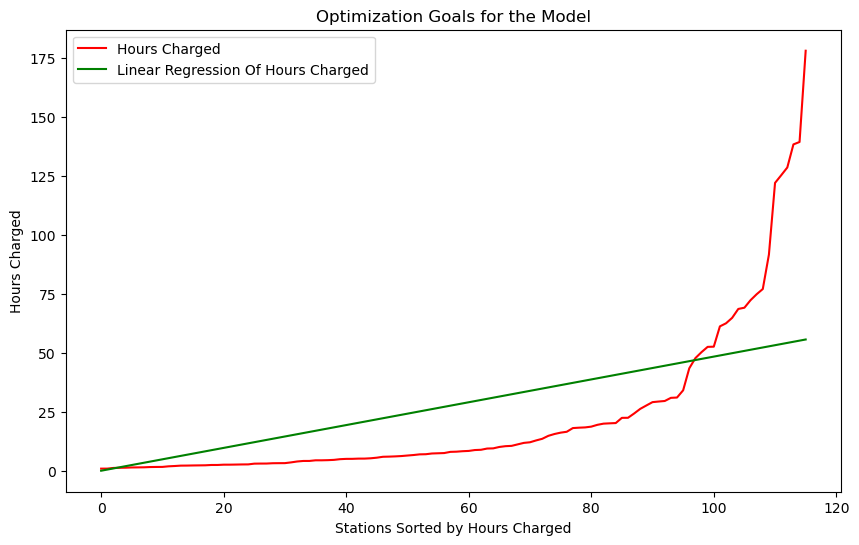

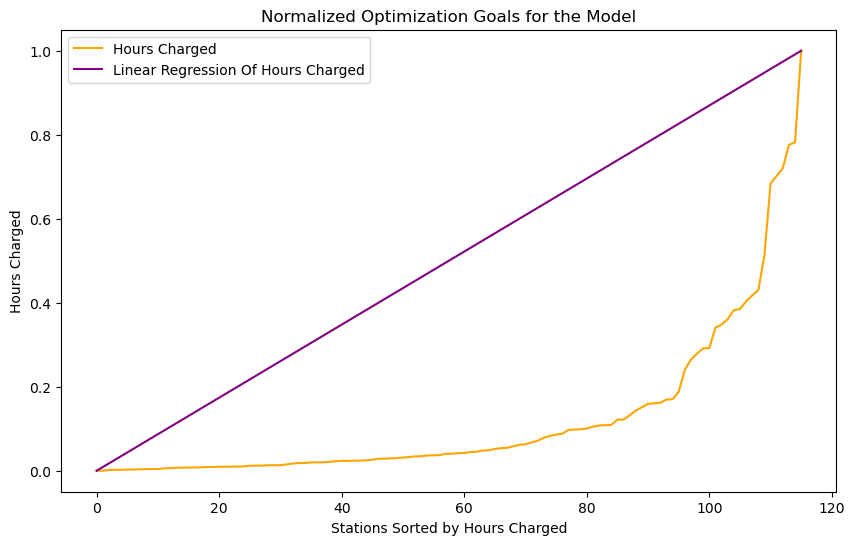

In [3]:
X = np.arange(len(df_moterway)).reshape(-1, 1)  # Element numbers as X
y_original = df_moterway['status_3_ratio_mean'].values.reshape(-1, 1)  # status_3_ratio_mean as Y, reshaped for scaler

# Normalize X and y
scaler_X = MinMaxScaler()
scaler_y = MinMaxScaler()

X_scaled = scaler_X.fit_transform(X)
y_scaled = scaler_y.fit_transform(y_original)

# Fit the model
model = LinearRegression(fit_intercept=False)
model.fit(X, y_original)

# Predict using the scaled features
y_lin = model.predict(X)
y_scaled_lin = scaler_y.fit_transform(y_lin)

# Plotting the results (optional)
plt.figure(figsize=(10, 6))
plt.plot(X, y_original, color='red', label='Hours Charged')
plt.plot(X, y_lin, color='green', label='Linear Regression Of Hours Charged')

plt.title('Optimization Goals for the Model')
plt.xlabel('Stations Sorted by Hours Charged')
plt.ylabel('Hours Charged')
plt.legend()
plt.show()

# Plotting the results (optional)
plt.figure(figsize=(10, 6))
plt.plot(X, y_scaled, color='orange', label='Hours Charged')
plt.plot(X, y_scaled_lin, color='purple', label='Linear Regression Of Hours Charged')

plt.title('Normalized Optimization Goals for the Model')
plt.xlabel('Stations Sorted by Hours Charged')
plt.ylabel('Hours Charged')
plt.legend()
plt.show()

Runs the gravity score calculation and generates the plot results

C++ program output:
 Time taken: 770 milliseconds



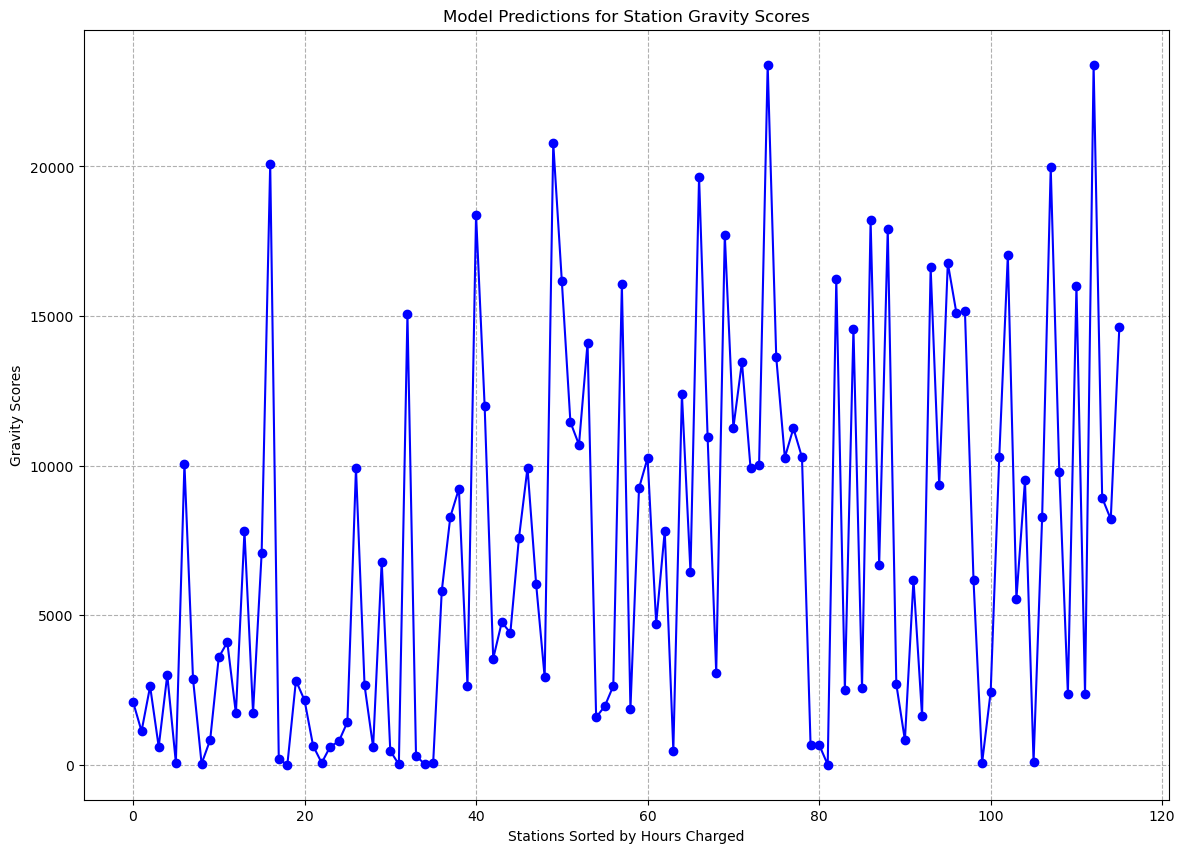

Mean Squared Error (MSE) on scaled data: 0.120450583116393
Root Mean Squared Error (RMSE) on scaled data: 0.3470599128628845


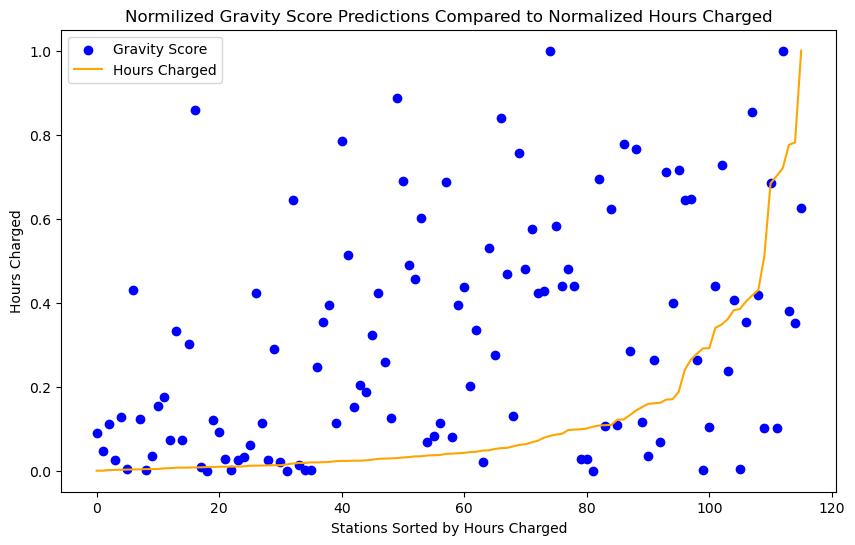

Mean Squared Error (MSE) on scaled data: 0.13120545117297364
Root Mean Squared Error (RMSE) on scaled data: 0.36222293021421714


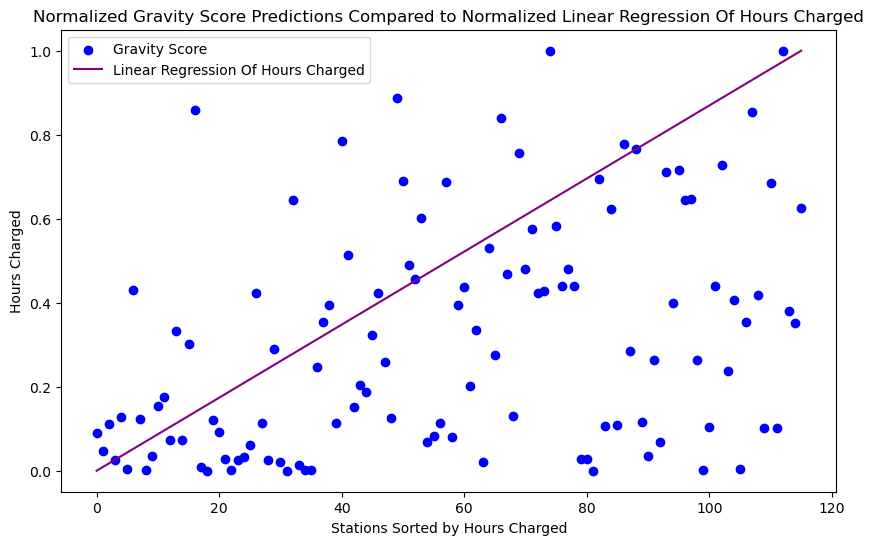

In [4]:

weights = { 
'traffic_weight': 0,
'fastFoods_weight': 99.20985560973496,
'hotels_weight': 4.934690512757022,
'motorwayLinks_weight': 35.860793012108964,
'motorways_weight': 99.11150706397427,
'restaurants_weight': 66.90143264496447,
'shopSupermarkets_weight': 44.84368475683832,
}

with open("weights_float.txt", "w") as file:
    for name, value in weights.items():
        file.write(f"{name} {float(value)}\n")


# Define the path to the compiled executable
executable_path = './gravityscore'

# The CSV file name to pass as an argument
csv_file_name = 'moterway.csv'

# Run the compiled C++ program with the CSV file name as an argument
result = subprocess.run([executable_path, csv_file_name], stdout=subprocess.PIPE, stderr=subprocess.PIPE, text=True)

# Process the result
if result.returncode == 0:
    print("C++ program output:\n", result.stdout)
else:
    print("Error running C++ program:\n", result.stderr)

df_gravity = pd.read_csv('gravityScoresWithDetails.csv')
#change all gravity that a negative to zero
df_gravity['gravity'] = df_gravity['gravity'].apply(lambda x: 0 if x < 0 else x)

#plot df_gravity where x asis the the index and y axis the gravity
plt.figure(figsize=(14, 10))
plt.plot(df_gravity.index, df_gravity['gravity'], marker='o', linestyle='-', color='blue')
plt.xlabel('Stations Sorted by Hours Charged')
plt.ylabel('Gravity Scores')
plt.title('Model Predictions for Station Gravity Scores')
plt.grid(True, which="both", ls="--")
plt.show()

X = np.arange(len(df_moterway)).reshape(-1, 1)  # Element numbers as X
y = df_gravity['gravity'].values.reshape(-1, 1)
#y_original = df_moterway['status_3_ratio_mean'].values.reshape(-1, 1)  # status_3_ratio_mean as Y, reshaped for scaler


scaler_y = MinMaxScaler()

X_scaled = scaler_X.fit_transform(X)
y_gravity_scaled = scaler_y.fit_transform(y)


# Calculate MSE on the scaled predictions
mse_scaled = mean_squared_error(y_gravity_scaled, y_scaled)
rmse = np.sqrt(mse_scaled)

mse = mean_squared_error(y, y_original)

print(f"Mean Squared Error (MSE) on scaled data: {mse_scaled}")
print(f"Root Mean Squared Error (RMSE) on scaled data: {rmse}")


# Plotting the results (optional)
plt.figure(figsize=(10, 6))
plt.scatter(X, y_gravity_scaled, color='blue', label='Gravity Score')
plt.plot(X, y_scaled, color='orange', label='Hours Charged')
plt.title('Normilized Gravity Score Predictions Compared to Normalized Hours Charged')
plt.xlabel('Stations Sorted by Hours Charged')
plt.ylabel('Hours Charged')
plt.legend()
plt.show()


# Calculate MSE on the scaled predictions
mse_scaled = mean_squared_error(y_gravity_scaled, y_scaled_lin)
rmse = np.sqrt(mse_scaled)

# If you want to calculate MSE on the original scale
mse = mean_squared_error(y, y_original)

print(f"Mean Squared Error (MSE) on scaled data: {mse_scaled}")
print(f"Root Mean Squared Error (RMSE) on scaled data: {rmse}")

# Plotting the results (optional)
plt.figure(figsize=(10, 6))
plt.scatter(X, y_gravity_scaled, color='blue', label='Gravity Score')
plt.plot(X, y_scaled_lin, color='purple', label='Linear Regression Of Hours Charged')
plt.title('Normalized Gravity Score Predictions Compared to Normalized Linear Regression Of Hours Charged')
plt.xlabel('Stations Sorted by Hours Charged')
plt.ylabel('Hours Charged')
plt.legend()
plt.show()

